# <font color='green'>ĐỒ ÁN 3: Fake news detection
## Danh sách các thành viên và bảng phân công công việc:
| STT | Họ và tên | MSSV | Nội dung công việc | Hoàn thành |
| :--- | :---: | :---: | :---: | ---: |
| 01 | Lưu Trường Dương | 19120489 || 100%|
| 02 | Nguyễn Phạm Quang Dũng | 19120485 |  | 100% |
| 03 | Huỳnh Quốc Duy | 19120494 |  | 100% |
| 04 | Phạm Đức Huy | 19120534 |  | 100% |
| 05 | Lê Thành Lộc | 19120562 |  | 100% |

## Import

In [63]:
import pandas as pd 
import re
import sys
import seaborn as sns;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Dữ liệu

- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật)

In [18]:
df = pd.read_csv('data.csv')
df1 = df.copy()
df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


In [19]:
df['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

- Dữ liệu gồm **123** tin thật và **100** tin giả.

## Tiền xử lí văn bản Tiếng Việt

### Lower case

Bằng cách tách từng từ bằng split(), sau đó nối các lower() từng từ lại với nhau để chuyển đoạn văn bản về dạng chữ thường hết

In [20]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,text,domain,label
0,thủ tướng abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,thủ tướng nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,choáng! cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,chưa bao giờ nhạc kpop lại dễ hát đến thế!!! g...,tintucqpvn.net,1
4,"đại học hutech sẽ áp dụng cải cách ""tiếq việt""...",www.gioitreviet.net,1


### Remove Stopwords

File **vietnamese_stopwords.txt** lấy từ [link github](https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

Để loại bỏ stopwords ta thực hiện lần lượt 2 bước:
- Bước 1: đọc danh sách các stopwords từ link github ở trên, lưu vào list `vietnamese`
- Bước 2: sort các từ trong list `vietnamese` , viết hàm `remove_stopwords` duyệt theo thứ tự sort giảm dần để đảm bảo luôn ưu tiên xóa các stopword dài nhất có thể
- Bước 3: apply hàm `remove_stopwords`  cho cột `text` của `df`

Bước 1:


In [21]:
def get_stopwords_list(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))
vietnamese = get_stopwords_list('vietnamese_stopwords.txt')

Bước 2:

In [22]:
temp = vietnamese.copy()
temp.sort(reverse=True)

def remove_stopwords(text):
    text_list = text.split()
    text_len = len(text_list)
    for word in temp:
        word_list = word.split()
        word_len = len(word_list)
        for i in range(text_len + 1 - word_len):
            if text_list[i:i+word_len] == word_list:
                text_list[i:i+word_len] = [None] * word_len
    return ' '.join(t for t in text_list if t)

Bước 3:

In [23]:
df['text'] = df['text'].apply(remove_stopwords)

### Remove noise


Dùng regex để loại bỏ các kí tư gây nhiễu (HTML tag, các ký hiệu đặc biệt như @, #,...) thông qua hàm `remove_tag`

In [24]:
TAG_1 = re.compile(r'<[^>]+>')
TAG_2 = re.compile("[@#$]")

def remove_tags(text):
    text = TAG_1.sub('', text)
    return TAG_2.sub('', text)
    
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word.isalnum()))

In [25]:
df['text'].sample()

178    quản lý dân cư hộ khẩu phủ nghị quyết 112 đơn ...
Name: text, dtype: object

### Remove punctuation (loại bỏ dấu câu)

Tiếp tục dùng regex để loại bỏ các dấu câu

In [26]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [27]:
df['text'][0]

'thủ tướng abe cúi đầu lỗi hành động phi thể thao tuyển nhật sankei thủ tướng nhật shinzo abe công khai gửi lỗi nhật hoàng toàn dân tinh thần thi đấu phi thể thao đội tuyển nhật world cup tối lượt trận vòng bảng world cup nhật phụ đội thua nhật vòng thẻ phạt thủ tướng nhật shinzo abe cúi đầu tinh thần võ sĩ đạo đội tuyển nhật hành động tinh thần thượng võ thi đấu world trích bất bình toàn hình ảnh kiên cường dân nhật đấu trường quốc đứng thành trách nhiệm gửi lỗi sâu sắc nhân abe cúi đầu trách nhiệm nhật nổi tiếng tinh trách nhiệm chất võ sĩ đội tuyển áo xanh mệnh danh nhật trích dội hâm mộ bóng đá lối bóng tiêu cố tình câu vé đi cụ phút trận vòng bảng trận colombia thắng senegal tỷ tỉ tương cầu thủ nhật hề gỡ cầu thủ nhật vui vẻ trận thua lan vé vòng 16 world cup fifa fair quy định 1 thẻ vàng 2 thẻ vàng thành thẻ đỏ thẻ đỏ nhật 4 thẻ vàng senegal sợ lãnh thẻ vàng nhật giết chết trận đấu phút liên tục chuyền bóng sân 5 phút cầu thủ nhật bóng sân đối bất chấp la huýt sáo cđv thầy trò hl

## Khám phá dữ liệu

### Ý nghĩa của từng trường thông tin


- `text` chứa nội dung của bài báo
- `domain` chứa nguồn của bài báo 
- `label` để phân loại bài báo đúng hay sai, 1 là Fake và 0 là Real

### Kiểm tra dữ liệu bị thiếu, sai kiểu dữ liệu

Có cột nào thiếu giá trị không?

In [28]:
df.isna().sum()

text      0
domain    0
label     0
dtype: int64

Kiểu dữ liệu của các cột?

In [29]:
df.dtypes

text      object
domain    object
label      int64
dtype: object

### Kiểm tra phân bố class có chênh lệch hay không

Kiểm tra số lượng label Fake và label Real

In [77]:
ax = df.label.value_counts()
ax

0    123
1    100
Name: label, dtype: int64

Biểu đồ so sánh 2 label

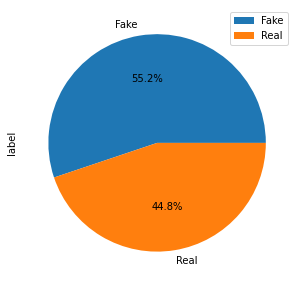

In [78]:
ax = ax.to_frame()

ax.index = ['Fake','Real']
ax.plot.pie(y='label',figsize=(5,5),autopct='%1.1f%%')
plt.show()


Như ta có thể thây số lượng label Fake và label Real không có quá chênh lệch, có thể dễ để mang lại hiệu quả cao trong quá trình học máy

### Các thông tin thống kê của văn bản

- Chiều dài mỗi record
- Số ký tự ở mỗi record

In [31]:
df1['word_count'] = df1["text"].apply(lambda x: len(str(x).split(" ")))
df1.drop(columns="domain").head()

,text,label,word_count
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,1,482
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,1,188
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,1,240
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,1,671
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",1,1943


Tìm hiểu thêm về số lượng kí tự

1. Xem các thông số cơ bản của cột `word count`

In [52]:
df1['word_count'].describe()

count     223.000000
mean      552.686099
std       393.414288
min        67.000000
25%       281.000000
50%       438.000000
75%       718.000000
max      2266.000000
Name: word_count, dtype: float64

2. Biểu đồ phân bố của `word_count`

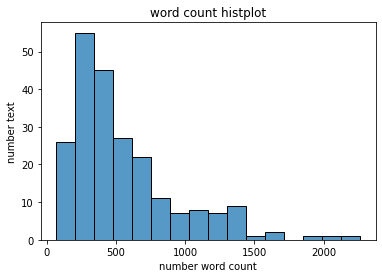

In [59]:
ax = sns.histplot(df1['word_count'])
ax.set(xlabel = 'number word count',ylabel = 'number text', title='word count histplot');

## Mô hình hóa 

### Tách dữ liệu

Sử dụng hàm `train_test_split` để chia dữ liệu ra thành các phần `test` và `train`

In [32]:
x = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                  random_state=42, 
                                                  test_size=0.25
                                                     , shuffle=True
                                                   )

### Chuyển đổi dữ liệu

dùng `TfidfVectorizer` để chuyển data sang vector

In [33]:
tfidf = TfidfVectorizer(min_df=2,max_df=0.8,  max_features=None,ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)
tftrain = tfidf.fit_transform(X_train)
tftest = tfidf.transform(X_test)

### Đồ thị hóa dữ liệu
Ta dùng PCA để giảm chiều giữa liệu thành dữ liệu 2 chiều để có thể mô hình hóa dữ liệu ở dạng này.

In [34]:
# 1. Choose the model class
from sklearn.decomposition import TruncatedSVD
# 2. Instantiate the model with hyperparameters
model = TruncatedSVD(n_components=2)
# 3. fit to data. Notice y not specified!
model.fit(tftrain)
# 4. tranform the data to two dimensions
X_2D = model.transform(tftrain)

In [35]:
visualization = pd.DataFrame(y_train)
visualization['SVD1'] = X_2D[:, 0]
visualization['SVD2'] = X_2D[:, 1]

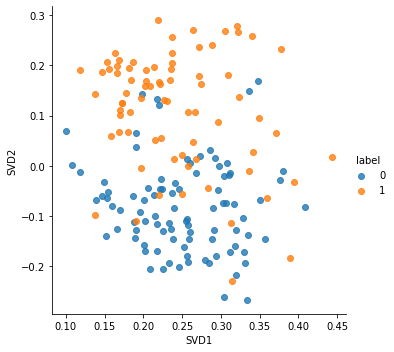

In [36]:
sns.lmplot(x="SVD1", y="SVD2", hue='label', 
           data=visualization, fit_reg=False);

### Training bằng các mô hình học máy

#### Plot

In [37]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Logicstic Regession

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

Accuracy:   0.911
Confusion matrix, without normalization


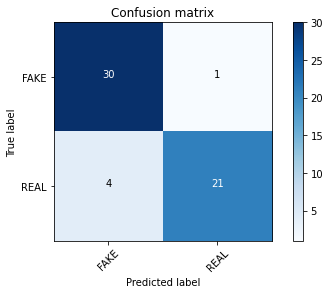

In [40]:
model = LogisticRegression()
model.fit(tftrain,y_train)

pred = model.predict(tftest)
score = accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [41]:
import pickle
from sklearn.pipeline import Pipeline

In [42]:
model_pipe = Pipeline([('tfidf',tfidf),('log',model)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
import pickle
pickle_out = open("log_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Naive-Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

Accuracy:   0.911
Confusion matrix, without normalization


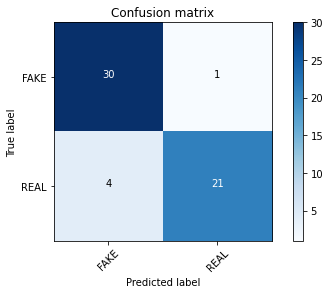

In [44]:
classifier=MultinomialNB()
classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [45]:
model_pipe = Pipeline([('tfidf',tfidf),('naive_bayes',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
import pickle
pickle_out = open("naivebayes_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### Deep Learning: Nerual Network

In [46]:
from sklearn.neural_network import MLPClassifier

Accuracy:   0.928571
Confusion matrix, without normalization


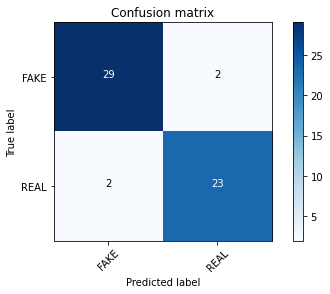

In [47]:
classifier=MLPClassifier(alpha=0.01,hidden_layer_sizes=(50), activation='relu', solver='lbfgs', random_state=0, max_iter=10000)

classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
print("Accuracy:   %0.6f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

- Thêm siêu tham số ``alpha`` từ **0-100** để tìm ra giá trị Accuracy tốt nhất.

In [48]:
train_accs = []
val_accs = []
alphas = [0,0.01,0.1, 1, 10, 100]
best_val_acc = 0
best_alpha = None
get_parameters = []
for alpha in alphas:
    model = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='lbfgs', random_state=0, 
                            max_iter=10000, alpha=alpha)
    model.fit(tftrain, y_train)
    val_y_predict = model.predict(tftest)
    # calculate accuracy
    val_err = model.score(tftest, y_test)
    val_accs.append(val_err)
    # get alpha and num_top_cp_values
    get_parameters.append((alpha))
best_val_acc = max(val_accs)
best_alpha = get_parameters[val_accs.index(max(val_accs))]
print(f'Best accuracy score is {round(best_val_acc,6)} with alpha= {best_alpha}')
'Finish!'

Best accuracy score is 0.928571 with alpha= 0.01


'Finish!'

In [49]:
model_pipe = Pipeline([('tfidf',tfidf),('log',classifier)])
model_pipe.fit(X_train,y_train)

### Create a Pickle file using serialization 
import pickle
pickle_out = open("mlp_classifier.pkl","wb")
pickle.dump(model_pipe, pickle_out)
pickle_out.close()

#### K Neighbors

In [50]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy:   0.893
Confusion matrix, without normalization


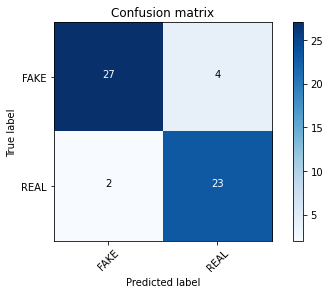

In [51]:
classifier= KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='minkowski')

classifier.fit(tftrain,y_train)
pred = classifier.predict(tftest)
score = accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])